In [1]:
import IPython.display as ipd

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import torch

from models.tacotron import Tacotron2
from data.ljspeech import vocab, char2idx, text_normalize

from torchaudio.prototype.pipelines import HIFIGAN_VOCODER_V3_LJSPEECH as bundle

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

In [3]:
sampling_rate = 22050
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Tacotron2(vocab_size=len(vocab),
                    mask_padding=True,
                    n_mel_channels=80,
                    n_frames_per_step=1,
                    symbols_embedding_dim=512)

checkpoint_path = "checkpoints/train0/train0_100.pt"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
_ = model.cuda().eval()


vocoder = bundle.get_vocoder()
vocoder.cuda()


/tmp/ipykernel_39976/791709532.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


HiFiGANVocoder(
  (conv_pre): Conv1d(80, 256, kernel_size=(7,), stride=(1,), padding=(3,))
  (ups): ModuleList(
    (0): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
    (1): ConvTranspose1d(128, 64, kernel_size=(16,), stride=(8,), padding=(4,))
    (2): ConvTranspose1d(64, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  )
  (resblocks): ModuleList(
    (0): ResBlock2(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      )
    )
    (1): ResBlock2(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
        (1): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(12,), dilation=(6,))
      )
    )
    (2): ResBlock2(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,))
        (1): 

In [9]:
text = "than in the same operations with ugly ones."
text = text_normalize(text)
text = [[char2idx[char] for char in text]]
sequence = torch.IntTensor(text).cuda()

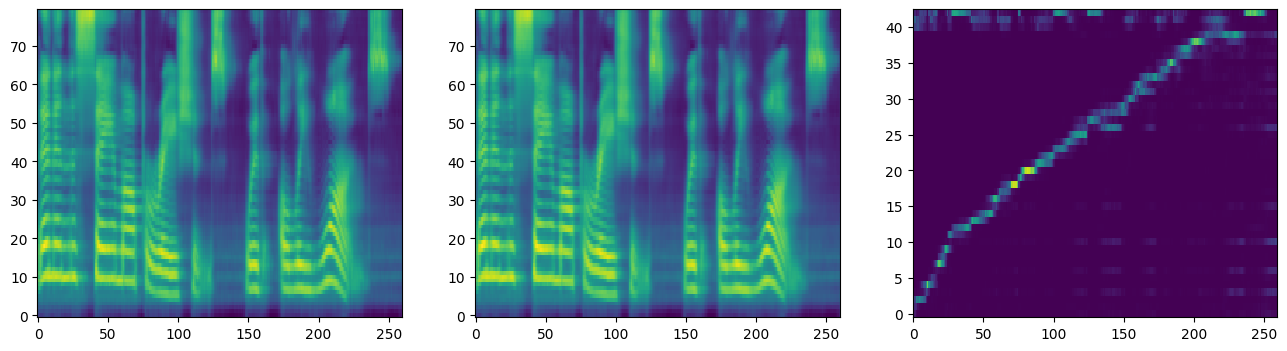

In [10]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [11]:
audio_output = vocoder(mel_outputs).squeeze(0)
audio_output = audio_output.detach().cpu().numpy()

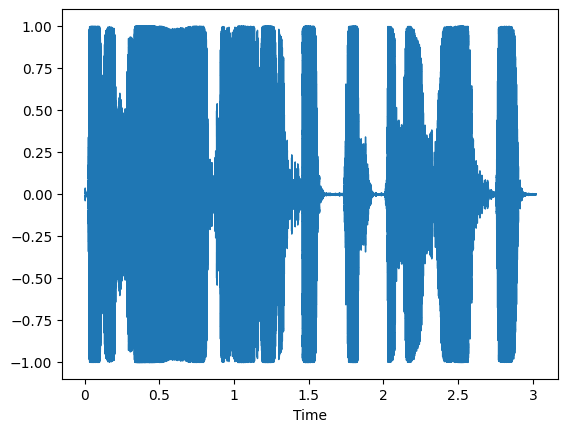

In [12]:
import librosa

librosa.display.waveshow(audio_output, sr=bundle.sample_rate)

In [14]:
ipd.Audio(audio_output, rate=bundle.sample_rate) 